In [41]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from graph_toolset import coreness, degs
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [24]:
def total(graph, keys):
    if 'total' in keys:
        return {'total': graph.V}
    else:
        return {}

In [25]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [26]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [54]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [28]:
def plot_2d(alphas, bs, data, last, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 3, data[key])
        cur = np.apply_along_axis(np.mean, 0, cur)
        
        CSF = ax.contourf(bs, alphas, cur, levels=100, label=str(key))
        # CS = ax.contour(x, y, z, levels=levels, colors='black', linestyles='dashed')
        fig.colorbar(CSF, ax=ax, orientation='horizontal')
        # plt.clabel(CS, fmt='%1.1f', colors='k', fontsize=14)  # contour line labels
        
    ax.legend()
    ax.set_title(title)
    plt.show()

In [29]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [13]:
def ER(t):
    return ErdosRenyi(*t)

n = 500
graphs = Pool(32).map(ER, [(n, 4. / n) for _ in range(500)])

In [11]:
bs = partition(0, 8, 256)
alphas = [.1]

In [21]:
res = calc('mono', alphas, bs, graphs[:10], 1000, set_builder=total, keys=['total'])

#1 passed in 174.14846777915955,  projected end in 26.12227467298508 minutes
#2 passed in 172.53873538970947,  projected end in 23.112718852361045 minutes
#3 passed in 176.90738153457642,  projected end in 20.36220969226625 minutes
#4 passed in 172.99625515937805,  projected end in 17.414920085668562 minutes
#5 passed in 174.1957507133484,  projected end in 14.513225408395131 minutes
#6 passed in 171.29981207847595,  projected end in 11.578825333383348 minutes
#7 passed in 171.70291304588318,  projected end in 8.669985810347965 minutes
#8 passed in 173.95801544189453,  projected end in 5.782321253418923 minutes
#9 passed in 173.04019403457642,  projected end in 2.890367634208114 minutes
#10 passed in 175.6772027015686,  projected end in 0.0 minutes
time elapsed = 1736.4900512695312


<IPython.core.display.Javascript object>


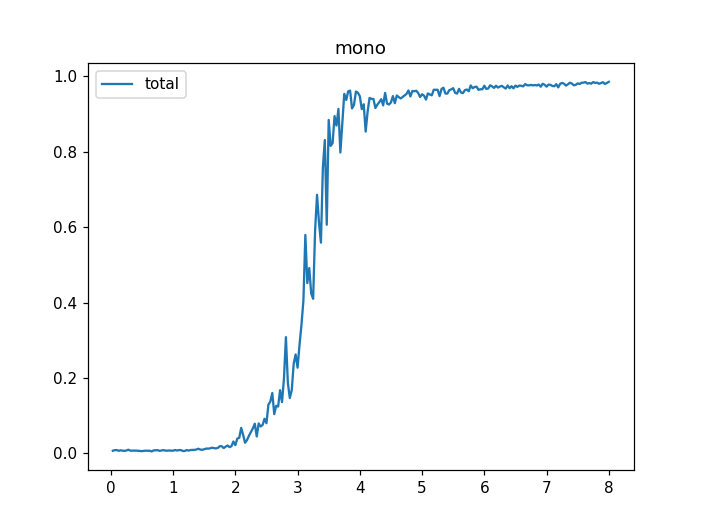

In [22]:
plot_means(bs, cut_alpha(res, 0), 1, keys=['total'], title='mono')

In [36]:
def SF(t):
    return ScaleFree(*t)

graphs = Pool(32).map(SF, [(500, 4) for _ in range(10)])

In [38]:
res = calc('mono', alphas, bs, graphs[:10], 100, set_builder=total, keys=['total'])

#1 passed in 22.563167333602905,  projected end in 3.3844805717468263 minutes
#2 passed in 22.71544337272644,  projected end in 3.0187177022298175 minutes
#3 passed in 22.87339758872986,  projected end in 2.6504745761553448 minutes
#4 passed in 22.52235436439514,  projected end in 2.2669586300849915 minutes
#5 passed in 22.676137447357178,  projected end in 1.8892559687296548 minutes
#6 passed in 22.73232126235962,  projected end in 1.512104860941569 minutes
#7 passed in 22.694105863571167,  projected end in 1.1341749617031642 minutes
#8 passed in 22.442479372024536,  projected end in 0.7551158169905344 minutes
#9 passed in 22.976770162582397,  projected end in 0.37815851105584036 minutes
#10 passed in 22.57456064224243,  projected end in 0.0 minutes
time elapsed = 226.78357648849487


<IPython.core.display.Javascript object>


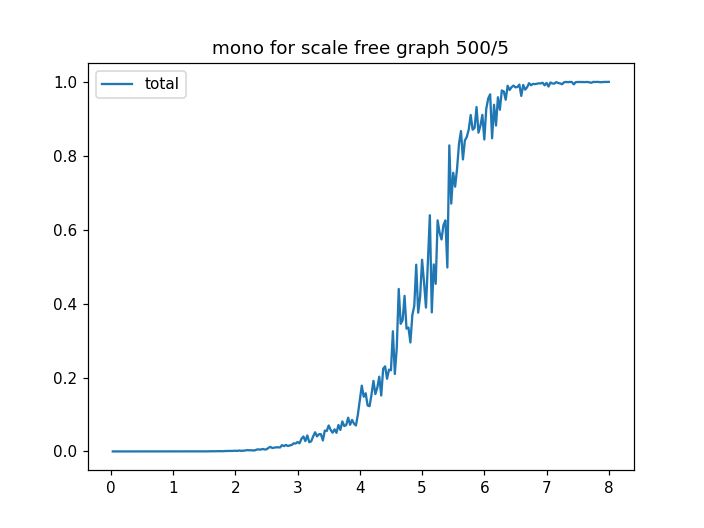

In [39]:
plot_means(bs, cut_alpha(res, 0), 10, keys=['total'], title='mono for scale free graph 500/5')

In [45]:
def SW(t):
    return SmallWorld(*t)

graphs = Pool(32).map(SW, [(500, 5, .5) for _ in range(500)])

In [51]:
res = calc('mono', alphas, [4], graphs[:50], 20000, set_builder=total, keys=['total'])

#1 passed in 279.5230734348297,  projected end in 228.27720487117767 minutes
#2 passed in 280.6387228965759,  projected end in 224.0660385131836 minutes
#3 passed in 281.2119619846344,  projected end in 219.6931474381023 minutes
#4 passed in 282.9997127056122,  projected end in 215.50604056517284 minutes
#5 passed in 284.78093814849854,  projected end in 211.3745189666748 minutes
#6 passed in 281.891788482666,  projected end in 206.68469265302022 minutes
#7 passed in 281.3089714050293,  projected end in 201.93276082617896 minutes
#8 passed in 279.2396945953369,  projected end in 197.01566291153432 minutes
#9 passed in 284.19473814964294,  projected end in 192.5332133301982 minutes
#10 passed in 280.51266145706177,  projected end in 187.75448749860126 minutes
#11 passed in 279.16123843193054,  projected end in 182.91469747695055 minutes
#12 passed in 280.17900562286377,  projected end in 178.15981112851037 minutes
#13 passed in 279.1927635669708,  projected end in 173.37128424155404 min

<IPython.core.display.Javascript object>


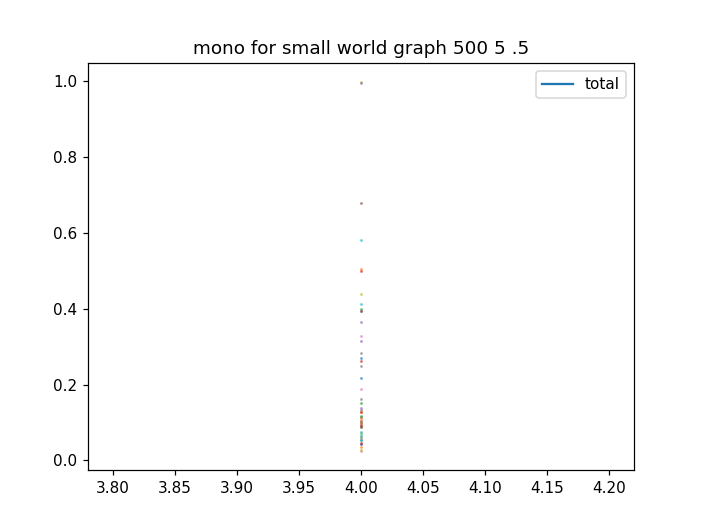

In [55]:
plot_means([4], cut_alpha(res, 0), 2000, keys=['total'], title='mono for small world graph 500 5 .5', show_data=True)

<IPython.core.display.Javascript object>


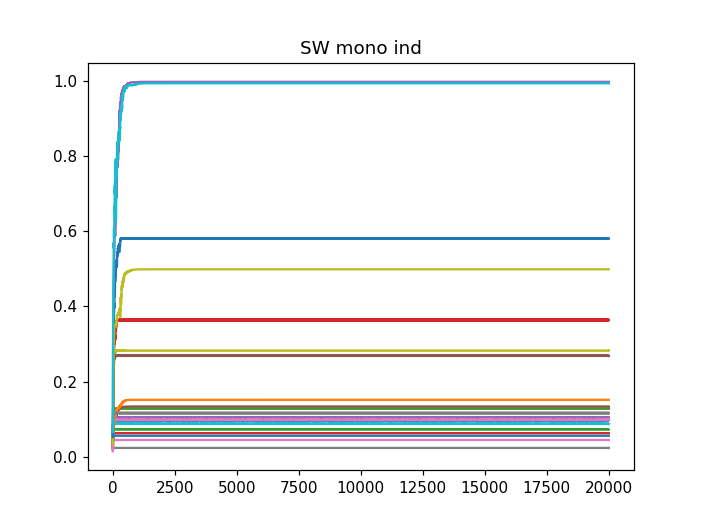

In [60]:
plot_individual(res, .5, ['total'], 'SW mono ind')

<IPython.core.display.Javascript object>


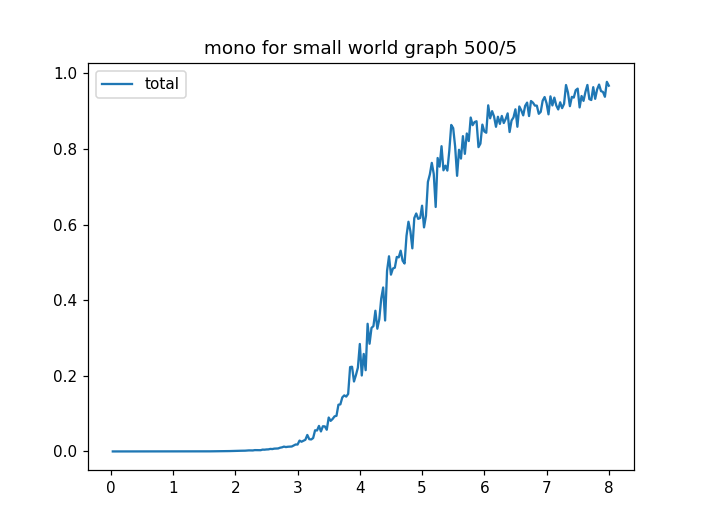

In [50]:
plot_means(bs, cut_alpha(res, 0), 50, keys=['total'], title='mono for small world graph 500/5')